In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Data

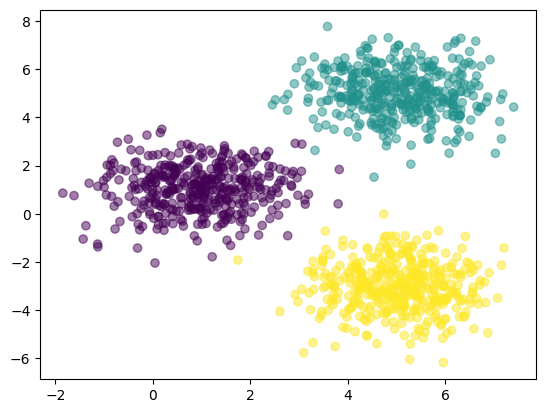

In [4]:
n_per_clust = 400
blur = 1

A = [1,1]
B = [5,5]
C = [5,-3]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

labels_np = np.hstack((
    np.zeros(n_per_clust),
    np.ones(n_per_clust),
    1 + np.ones(n_per_clust)
))

data_np = np.hstack((
    a,b,c
)).T

labels = torch.tensor(labels_np, dtype = torch.long)
data = torch.tensor(data_np, dtype = torch.float)

plt.scatter(data[:,0], data[:,1], c = labels, alpha =.5)

plt.show()

# Split

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model Arch

In [6]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(2, 16)
    self.f1 = nn.Linear(16,32)
    self.f2 = nn.Linear(32, 32)
    self.output = nn.Linear(32, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = self.f1(x)
    x = F.relu(x)
    x = self.f2(x)
    x = F.relu(x)
    x = self.output(x)

    return x

# Model Setup

Lerning Rate Scheduler Settings:

* step_size - how often we change learning rate
* gamma - multiplicative factor that we change the the learning rate by

In [27]:
def ModelSetup():
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma = 1/2)
  return ann, loss_fn, optimizer, scheduler

# Test The Change in Learning Rate

In [29]:
ann, loss_fn, optimizer, scheduler = ModelSetup()

for epoch in range(3):
  for batch in range(10):
    print(f'Epoch: {epoch} | Batch: {batch} | LR = {scheduler.get_last_lr()[0]}')
    scheduler.step()

Epoch: 0 | Batch: 0 | LR = 0.001
Epoch: 0 | Batch: 1 | LR = 0.001
Epoch: 0 | Batch: 2 | LR = 0.001
Epoch: 0 | Batch: 3 | LR = 0.001
Epoch: 0 | Batch: 4 | LR = 0.001
Epoch: 0 | Batch: 5 | LR = 0.0005
Epoch: 0 | Batch: 6 | LR = 0.0005
Epoch: 0 | Batch: 7 | LR = 0.0005
Epoch: 0 | Batch: 8 | LR = 0.0005
Epoch: 0 | Batch: 9 | LR = 0.0005
Epoch: 1 | Batch: 0 | LR = 0.00025
Epoch: 1 | Batch: 1 | LR = 0.00025
Epoch: 1 | Batch: 2 | LR = 0.00025
Epoch: 1 | Batch: 3 | LR = 0.00025
Epoch: 1 | Batch: 4 | LR = 0.00025
Epoch: 1 | Batch: 5 | LR = 0.000125
Epoch: 1 | Batch: 6 | LR = 0.000125
Epoch: 1 | Batch: 7 | LR = 0.000125
Epoch: 1 | Batch: 8 | LR = 0.000125
Epoch: 1 | Batch: 9 | LR = 0.000125
Epoch: 2 | Batch: 0 | LR = 6.25e-05
Epoch: 2 | Batch: 1 | LR = 6.25e-05
Epoch: 2 | Batch: 2 | LR = 6.25e-05
Epoch: 2 | Batch: 3 | LR = 6.25e-05
Epoch: 2 | Batch: 4 | LR = 6.25e-05
Epoch: 2 | Batch: 5 | LR = 3.125e-05
Epoch: 2 | Batch: 6 | LR = 3.125e-05
Epoch: 2 | Batch: 7 | LR = 3.125e-05
Epoch: 2 | Batch: 8

Every *step_size* step we get $$ lr = \gamma \times lr $$

# Actual Model Setup

In [30]:
def ModelSetup(initial_lr):
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = initial_lr)
  step_size = batch_size * len(train_dataloader)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= step_size, gamma = .5)
  return ann, loss_fn, optimizer, scheduler

In [31]:
batch_size * len(train_dataloader)

960

$\text{batch_size} \times \text{len(train_dataloader)}$ is total amount of samples in our training set. Therefore, after total number of samples in training set we're going to halve *learning_rate* due to *gamma* parameter.

# Model Train

In [53]:
def ModelTrain(epochs, initial_lr, toggle_dynamic_lr, verbose):
  ann, loss_fn, optimizer, scheduler = ModelSetup(initial_lr = initial_lr)

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)
  lr_hist = []

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      batch_acc = 100 * torch.mean(
          (torch.argmax(batch_y_hat, axis = 1) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      lr_hist.append( scheduler.get_last_lr()[0] )

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

      #### HERE IS SCHEDULER CODE
      if toggle_dynamic_lr:
        scheduler.step()
      ############################

    train_loss = torch.mean(batch_losses)
    train_losses[epoch] = train_loss
    train_acc = torch.mean(batch_accs)
    train_accs[epoch] = train_acc

    ann.eval()
    with torch.no_grad():
      X_test, y_test = next(iter(test_dataloader))
      test_y_hat = ann(X_test)

      test_loss = loss_fn(test_y_hat, y_test)
      test_losses[epoch] = test_loss

      test_acc = 100 * torch.mean(
          (torch.argmax(test_y_hat, axis = 1) == y_test).float()
      )
      test_accs[epoch] = test_acc

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch}, Train Loss: {train_loss:.2f}, Train Acc: {train_acc:.2f}, Test Loss: {test_loss:.2f}, Test Acc: {test_acc:.2f}, LR: {scheduler.get_last_lr()[0]}')

  return train_losses, train_accs, test_losses, test_accs, lr_hist

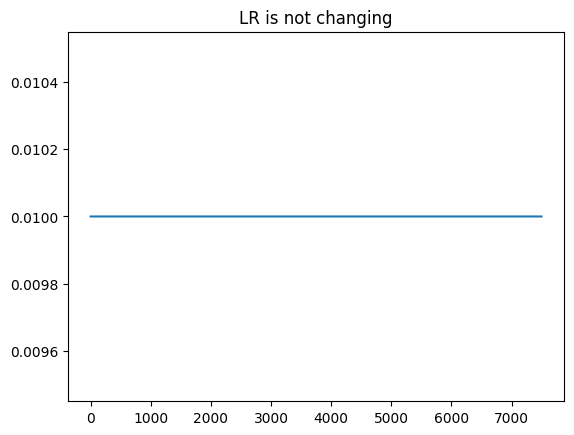

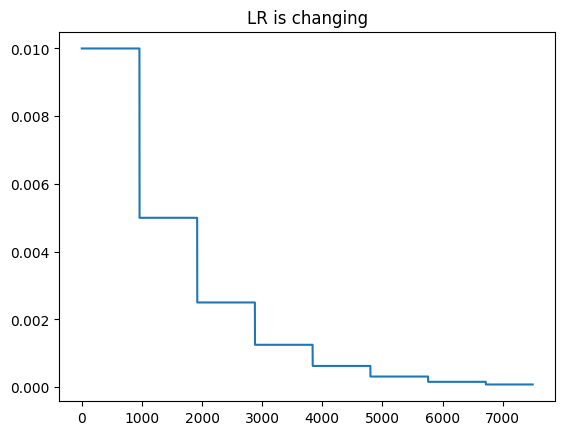

In [57]:
train_losses_stat, train_accs_stat, test_losses_stat, test_accs_stat, lr_hist_stat = ModelTrain(epochs = 500, initial_lr = 0.01, toggle_dynamic_lr = False, verbose = False)
plt.plot(lr_hist_stat)
plt.title('LR is not changing')
plt.show()

train_losses_dyn, train_accs_dyn, test_losses_dyn, test_accs_dyn, lr_hist_dyn = ModelTrain(epochs = 500, initial_lr = 0.01, toggle_dynamic_lr = True, verbose = False)
plt.plot(lr_hist_dyn)
plt.title('LR is changing')
plt.show()

# Plot Single Run

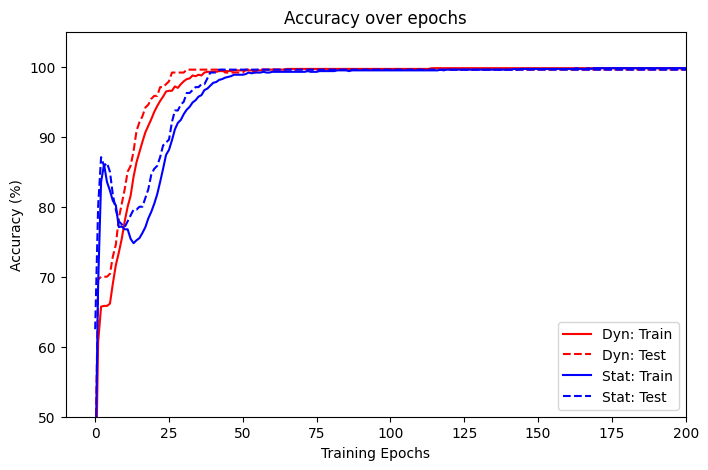

In [67]:
fig = plt.figure(figsize = (8,5))

plt.plot(train_accs_dyn, 'r', label = 'Dyn: Train')
plt.plot(test_accs_dyn, 'r--', label = 'Dyn: Test')

plt.plot(train_accs_stat, 'b', label = 'Stat: Train')
plt.plot(test_accs_stat, 'b--', label = 'Stat: Test')

plt.xlabel('Training Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.xlim([-10, 200])
plt.ylim([50,105])
plt.show()